<a href="https://colab.research.google.com/github/yubars/ML-and-Cybersecurity-projects/blob/main/IDS_using_Random_Forest_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intrusion Detection System using ML model to predict attacks
#### Using KDD dataset to predict attacks correctly.

### Learning Objectives
* Learn to create and evaluate Intrusion Detection System (IDS) using Random Forest Classifier.
* Visualize the predictions made by the algorithm with Confusion Matrix and performance metrics.


### Imports

Import all the required libraries including pandas, numpy, and matplotlib for the lab.

In [ ]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-white')
import seaborn as sns

### Mount Google Drive

In the code cell below, we mount the google drive to the colab environment so that we have access to the local version of the dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Read CSV

We read the csv file using pandas in the code below.

In [ ]:
mydata = pd.read_csv('/content/drive/MyDrive/Intro2MLDatasets/Lab5/KDDCup99.csv')

### Analyzing Dataset

This code allows us to see the length and width of the dataset. The first integer denotes the number of rows and the second integer denotes the number of columns in the dataset.

In [ ]:
mydata.shape

(494020, 42)

The code cells below help us visualize the dataest in every angle. We use the given functions from pandas to display the shape, first 100 data, and the features in the dataset.

In [ ]:
mydata.head(100)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,lnum_compromised,lroot_shell,lsu_attempted,lnum_root,lnum_file_creations,lnum_shells,lnum_access_files,lnum_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.00,9,9,1.0,0.0,0.11,0.00,0.0,0.0,0.0,0.0,normal
1,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.00,19,19,1.0,0.0,0.05,0.00,0.0,0.0,0.0,0.0,normal
2,0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.00,29,29,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,normal
3,0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.00,39,39,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.00,49,49,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,tcp,http,SF,337,330,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,12,12,0.0,0.0,0.0,0.0,1.0,0.0,0.00,12,255,1.0,0.0,0.08,0.01,0.0,0.0,0.0,0.0,normal
96,0,tcp,http,SF,293,38125,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,22,22,0.0,0.0,0.0,0.0,1.0,0.0,0.00,22,255,1.0,0.0,0.05,0.01,0.0,0.0,0.0,0.0,normal
97,0,tcp,http,SF,171,280,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,26,0.0,0.0,0.0,0.0,1.0,0.0,0.08,6,255,1.0,0.0,0.17,0.02,0.0,0.0,0.0,0.0,normal
98,0,tcp,http,SF,178,1973,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.00,16,255,1.0,0.0,0.06,0.02,0.0,0.0,0.0,0.0,normal


In [ ]:
mydata.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'lnum_compromised', 'lroot_shell',
       'lsu_attempted', 'lnum_root', 'lnum_file_creations', 'lnum_shells',
       'lnum_access_files', 'lnum_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'label'],
      dtype='object')

### Identify Features to drop

In the code below, we identify the features which are same in every instances. 'lnum_outbound_cmds' and 'is_host_login' are the two features which has same data in every row of the dataset. Hence, these features will not help model to predict the attacks and are not necessary in the dataset that will be used to train a model.  


In [ ]:
cols_to_drop = []

"""
Check if column has any dissimilar data or not.
If Column with no dissimilar data, add to cols_to_drop as it will be insignificant for model training.
"""

for (columnName,columnData) in mydata.iteritems():
  
  if columnName == 'logged_in' or columnName == 'dst_host_same_srv_rate':
    
    newdata = mydata[(mydata[columnName] != 1) | (mydata[columnName] != 1.00)]
    if newdata.empty:
      cols_to_drop.append(columnName)
  else:
    #print(columnData)
    newdata = mydata[(mydata[columnName] != 0) | (mydata[columnName] != 0.00)]
    if newdata.empty:
      #print (columnName)
      #print(newdata)
      cols_to_drop.append(columnName)
     
print(cols_to_drop)

['lnum_outbound_cmds', 'is_host_login']


### Drop Features

The features we identified as futile are now dropped from the dataset we use to train the model. An original copy of the dataset is kept safe in a new variable. It is always smart to keep a copy of the original dataset. 

In [ ]:
mydata_orig = mydata.copy()
mydata.drop(columns=cols_to_drop, inplace=True)
cols_to_drop = []

### Visualize type of Attacks
In the given dataframe, we will only be working with the select attack types from the dataset. We will be using the top 8 more frequent attacks available in the dataset.

In [ ]:
dd = mydata.groupby('label').size()
dd.sort_values()

label
spy                     2
perl                    3
phf                     4
multihop                7
ftp_write               8
loadmodule              9
rootkit                10
imap                   12
warezmaster            20
land                   21
buffer_overflow        30
guess_passwd           53
nmap                  231
pod                   264
teardrop              979
warezclient          1020
portsweep            1040
ipsweep              1247
satan                1589
back                 2203
normal              97277
neptune            107201
smurf              280790
dtype: int64

In [ ]:
attacks = ['normal', 'neptune', 'smurf', 'back', 'satan', 'ipsweep', 'portsweep', 'warezclient']
mydata = mydata[mydata['label'].isin(attacks)]

### Identify missing values

The code below helps us identify features in the dataset which have missing values in it. Machine Learning model needs to have a dataset with no missing values. Hence, it is a part of the data preprocessing to check if there are any missing values in the dataset.

In [ ]:
#finds column with missing values or null values 
def print_missing_values(data):
  data_null = pd.DataFrame(len(data) - data.notnull().sum(), columns = ['Count'])
  data_null = data_null[data_null['Count'] > 0].sort_values(by='Count', ascending=False)
  data_null = data_null/len(data)*100
  return data_null

### Missing values observation

As we can see below, there seems to be no missing values in any feature in the dataset. Hence, we can skip the part where we identify median value of the row and replace with missing value.

In [ ]:
print_missing_values(mydata)

,Count


### Numerical and Categorical Features

It is necessary to split the features into numerical and categorical values before we feed the dataset to the model. All the integers are regarded as the numerical features and all the rest are categorized as categorical features.

In [ ]:
def categorize(data):
  num_columns = []
  cat_columns = []

  #separate numerical and categorical features
  for col in data.columns.values:
    if data[col].dtypes == 'int64' or data[col].dtypes == 'float64':
      num_columns += [col]
    else: 
      cat_columns += [col]

  return [cat_columns, num_columns]

In [ ]:
categories = categorize(mydata)
categorical_features = categories[0]
numerical_features = categories[1]
print("Categorical Features", categorical_features)
print("Numerical Features", numerical_features)

Categorical Features ['protocol_type', 'service', 'flag', 'label']
Numerical Features ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'lnum_compromised', 'lroot_shell', 'lsu_attempted', 'lnum_root', 'lnum_file_creations', 'lnum_shells', 'lnum_access_files', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


### Identify the type of labels

Label is the column in the dateset which is what the model is going to predict using all the other features from the dataset. KDD dataset has multiple label hence making this multi-class classification.

In [ ]:
attacks = set()
for index, row in mydata.iterrows():
  attacks.add(row['label'])
print(attacks)

{'neptune', 'satan', 'smurf', 'warezclient', 'portsweep', 'normal', 'ipsweep', 'back'}


### Import Scaler and label encoder

Label Encoder helps encode the categorical features into numerical format. MinMaxScaler is one of the way of scaling and normalizing the data. 

In [ ]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

### Utilizing Label Encoder
Label Encoder converts the categorical features into numerical format so that the machine learning algorithm can understand it.

In [ ]:
def label_encode(data, categorical_features):
  data_encoded = data.copy()

  # Use Label Encoder for categorical columns (including target column)
  for feature in categorical_features:
      le = LabelEncoder()
      le.fit(data_encoded[feature])
      data_encoded[feature] = le.fit_transform(data_encoded[feature])
      if feature == 'label':
        le_name_mapping = dict(zip(le.transform(le.classes_), le.classes_))

  return (data_encoded, le_name_mapping)  

In [ ]:
data_encoded, label_mapping = label_encode(mydata, categorical_features)

### label_mapping
label_mapping variable is the hashmap which contains all the one-hot encoded numeric value and it's corresponding label.

In [ ]:
print(label_mapping)

{0: 'back', 1: 'ipsweep', 2: 'neptune', 3: 'normal', 4: 'portsweep', 5: 'satan', 6: 'smurf', 7: 'warezclient'}


### Visualize the label

As we can see in the result below, the label is converted into the numerical format from the categorical version for the model to understand and make predictions.

In [ ]:
labeled_attacks = set()
for index, row in data_encoded.iterrows():
  labeled_attacks.add(row['label'])
print(labeled_attacks)

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0}


In [ ]:
data_encoded.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,lnum_compromised,lroot_shell,lsu_attempted,lnum_root,lnum_file_creations,lnum_shells,lnum_access_files,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,1,22,9,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,3
1,0,1,22,9,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,3
2,0,1,22,9,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,3
3,0,1,22,9,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,3
4,0,1,22,9,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,3


### Utilizing Scaler

Similary, we make use of the MinMaxScaler to scale and normalize the data and make it ready to use for the Machine Learning model.

In [ ]:
def scale_data(data, numerical_features):
  data_encoded = data.copy()
  for feature in numerical_features:
      val = data_encoded[feature].values[:, np.newaxis]
      mms = MinMaxScaler()
      data_encoded[feature] = mms.fit_transform(val)
      
  data_encoded = data_encoded.astype(float)
  return data_encoded

In [ ]:
data_encoded = scale_data(data_encoded, numerical_features)

In [ ]:
data_encoded.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,lnum_compromised,lroot_shell,lsu_attempted,lnum_root,lnum_file_creations,lnum_shells,lnum_access_files,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0.0,1.0,22.0,9.0,2.610418e-07,0.001062,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015656,0.015656,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.035294,0.035294,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,3.0
1,0.0,1.0,22.0,9.0,3.446905e-07,0.000095,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015656,0.015656,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.074510,0.074510,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,3.0
2,0.0,1.0,22.0,9.0,3.389216e-07,0.000260,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015656,0.015656,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.113725,0.113725,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,3.0
3,0.0,1.0,22.0,9.0,3.158461e-07,0.000260,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011742,0.011742,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.152941,0.152941,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,3.0
4,0.0,1.0,22.0,9.0,3.129617e-07,0.000396,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011742,0.011742,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.192157,0.192157,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,3.0


In [ ]:
print(label_mapping)

{0: 'back', 1: 'ipsweep', 2: 'neptune', 3: 'normal', 4: 'portsweep', 5: 'satan', 6: 'smurf', 7: 'warezclient'}


### What is Random Forest?
Decision Trees are the fundamental part of the Random Forest Classifier. Random Forest consists of large number of individual decision trees that operate as an ensemble. The majority predictions from the individual decision trees is the ultimate prediction of the Random Forest Classifier.

Understanding Random Forest

https://towardsdatascience.com/understanding-random-forest-58381e0602d2


### RandomForest Classifier

We use Random Forest Machine learning technique as suggested and experimented by one of the research paper. The paper found that the Random Forest works particularly best with the KDD dataset. 

Mohammad  Almseidin  et  al.  “Evaluation  of  MachineLearning  Algorithms  for  Intrusion  Detection  System”.In:CoRRabs/1801.02330  (2018).  arXiv:  1801.02330.URL: http://arxiv.org/abs/1801.02330.

### Initilaizing Random Forest model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100)

### Model performance

The function below evaluates the accuracy, precision, recall, and F1 score of the prediction made on the test dataset while also generating the confusion matrix for the model.

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc, precision_score, recall_score

def get_model_performance(test_labels, predicted_labels):
  accuracy = accuracy_score(test_labels, predicted_labels)
  matrix = (confusion_matrix(test_labels, predicted_labels)/test_labels.shape[0]) * 100
  precision = precision_score(test_labels, predicted_labels, average='macro')
  recall = recall_score(test_labels, predicted_labels, average='macro')
  f1 = f1_score(test_labels, predicted_labels, average='macro')
  return accuracy, matrix, precision, recall, f1

### Plot Performance

The function below helps plot the confusion matrix generated from the get_model_performance function above.

In [ ]:
def plot_model_performance(matrix):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    sns.heatmap(matrix, annot=True, cmap='Blues', fmt='g')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(list(attacks))
    ax.yaxis.set_ticklabels(list(attacks))

## SECTION I 
### Using Imbalanced Dataset

### Create Features and Labels
labels contains all the labels from the dataset and features contains the dataframe except the values from label.

In [ ]:
from sklearn.utils import shuffle
data_encoded = shuffle(data_encoded)
labels = data_encoded['label']
features = data_encoded.drop('label', axis=1)

### Train and Test Data Split

It is absolutely necessary to split the data into training, testing, and validation to make sure Machine Learning algorithms are learning well and can make predictions as accurately as possible. Here we use train_test_split to split 80% of the data as the train, 10% as the test and the rest 10% as the validation dataset.

In [ ]:
from sklearn.model_selection import train_test_split 

train_features, rem_features, train_labels, rem_labels = train_test_split(features, labels, train_size=0.8, shuffle=True)
valid_features, test_features, valid_labels, test_labels = train_test_split(rem_features, rem_labels, test_size=0.5, shuffle=True)

print("Train Dataset Feature Shape: ")
print(train_features.shape)
print("Test Dataset Feature Shape: ")
print(test_features.shape)
print("Valid Dataset Feature Shape: ")
print(valid_features.shape)
print("Train Dataset label Shape: ")
print(train_labels.shape)
print("Test Dataset label Shape: ")
print(test_labels.shape)
print("Valid Dataset label Shape: ")
print(valid_labels.shape)

Train Dataset Feature Shape: 
(393893, 39)
Test Dataset Feature Shape: 
(49237, 39)
Valid Dataset Feature Shape: 
(49237, 39)
Train Dataset label Shape: 
(393893,)
Test Dataset label Shape: 
(49237,)
Valid Dataset label Shape: 
(49237,)


### Visualize labels 
As we  can see below, the labels present in the dataframe only belong to select few types of attack. The proportion of the attacks present in the dataset is not uniform.

In [ ]:
lst = []
for i in range(valid_labels.shape[0]):
    lst.append(int(valid_labels.iloc[i]))

print("Labels: ", lst)

Labels:  [6, 6, 3, 3, 6, 6, 2, 6, 6, 2, 6, 6, 6, 6, 3, 6, 6, 6, 3, 2, 3, 6, 6, 6, 6, 6, 2, 2, 3, 2, 6, 2, 6, 2, 6, 2, 6, 2, 2, 3, 3, 6, 3, 2, 3, 6, 6, 2, 6, 2, 6, 3, 6, 3, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 3, 6, 2, 6, 3, 6, 6, 6, 6, 3, 2, 6, 6, 3, 3, 6, 6, 6, 6, 3, 6, 2, 6, 6, 3, 6, 6, 6, 6, 2, 3, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 2, 6, 6, 3, 2, 6, 6, 3, 6, 6, 6, 2, 6, 2, 6, 7, 6, 6, 6, 2, 6, 2, 3, 6, 3, 3, 6, 2, 6, 2, 6, 2, 2, 3, 6, 3, 2, 3, 6, 6, 6, 1, 6, 3, 3, 2, 2, 3, 2, 0, 5, 3, 2, 6, 6, 3, 2, 6, 6, 6, 6, 6, 6, 2, 6, 3, 6, 6, 2, 6, 4, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 2, 3, 2, 6, 6, 2, 6, 6, 6, 6, 2, 6, 6, 6, 2, 6, 6, 2, 6, 6, 3, 6, 3, 3, 6, 2, 3, 3, 2, 6, 6, 6, 6, 3, 2, 6, 6, 3, 6, 2, 6, 2, 3, 6, 6, 3, 6, 3, 6, 6, 2, 6, 6, 3, 6, 6, 6, 6, 6, 2, 6, 6, 6, 1, 3, 3, 6, 3, 6, 6, 6, 6, 6, 2, 6, 6, 6, 2, 6, 6, 6, 2, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 2, 2, 3, 6, 6, 6, 6, 2, 3, 2, 6, 3, 6, 3, 6, 6, 6, 6, 6, 3, 6, 2, 2, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 3, 6, 6, 6, 6, 3, 2, 6, 6, 3, 

In [ ]:
print(label_mapping)

{0: 'back', 1: 'ipsweep', 2: 'neptune', 3: 'normal', 4: 'portsweep', 5: 'satan', 6: 'smurf', 7: 'warezclient'}


### Fit model
Fit the model with the features and labels dataframe created from the train_test_split.

In [ ]:
rf.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Testing

The test features and train features are used to predict the labels and test the performance of the Random Forest model.

The accuracy of the model using the training data.


In [ ]:
train_pred_labels = rf.predict(train_features)
accuracy, matrix, precision, recall, f1 = get_model_performance(train_labels, train_pred_labels)
print("The accuracy of the model: ", accuracy)
print("The precision of the model: ", precision)
print("The recall of the model: ", recall)
print("The f1 score of the model: ", f1)

The accuracy of the model:  0.9999898449578947
The precision of the model:  0.9999935890860601
The recall of the model:  0.9994730555538798
The f1 score of the model:  0.9997329926620491


The accuracy of the model using the test data.

In [ ]:
test_pred_labels = rf.predict(test_features)
accuracy, matrix, precision, recall, f1 = get_model_performance(test_labels, test_pred_labels)
print("The accuracy of the model: ", accuracy)
print("The precision of the model: ", precision)
print("The recall of the model: ", recall)
print("The f1 score of the model: ", f1)

The accuracy of the model:  0.9998578304933282
The precision of the model:  0.9999082809224319
The recall of the model:  0.993929649500845
The f1 score of the model:  0.996890384083096


The training accuracy and test accuracy doesn't seem to have a lot of difference. Hence, it shows that the model was not overfit.

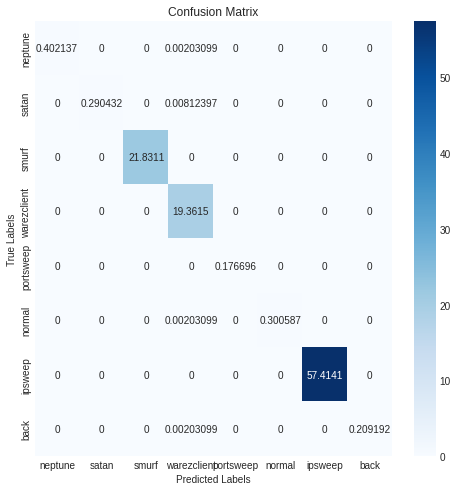

In [ ]:
plot_model_performance(matrix)

### Randomly selected instances for validation
The code below creates a list of lists named 'data' consisting of randomly selected instances from the validation dataset, where only features are included. It also creates a list of it's corresponding true labels named true_labels.

In [ ]:
import random
data = []
true_labels = []

for i in range(10):
  temp = random.randint(0, valid_features.shape[0])
  data.append(valid_features.iloc[temp].tolist())
  true_labels.append(valid_labels.iloc[temp])

for index, ele in enumerate(true_labels):
  true_labels[index] = label_mapping[int(ele)]

print(data)
print(true_labels)

[[0.0, 1.0, 45.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5088062622309197, 0.021526418786692758, 1.0, 1.0, 0.0, 0.0, 0.04, 0.06, 0.0, 1.0, 0.043137254901960784, 0.04, 0.07, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0], [0.0, 1.0, 45.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4892367906066536, 0.019569471624266144, 1.0, 1.0, 0.0, 0.0, 0.04, 0.06, 0.0, 1.0, 0.0392156862745098, 0.04, 0.06, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0], [0.0, 0.0, 14.0, 9.0, 1.4883707192251517e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 45.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4461839530332681, 0.03913894324853229, 1.0, 1.0, 0.0, 0.0, 0.09, 0.05, 0.0, 1.0, 0.0784313725490196, 0.08, 0.06, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0], [0.0, 1.0, 45.0, 5.0, 0.0, 0.0, 0.

### Create Dataframe
Create a pandas dataframe called new_data out of the list of lists of instances generated in the code cell above.

In [ ]:
new_data = pd.DataFrame(data)
print(new_data)
new_data.columns = valid_features.columns.tolist()
new_data

    0    1     2    3             4         5   ...    33    34   35   36   37   38
0  0.0  1.0  45.0  5.0  0.000000e+00  0.000000  ...  0.00  0.00  1.0  1.0  0.0  0.0
1  0.0  1.0  45.0  5.0  0.000000e+00  0.000000  ...  0.00  0.00  1.0  1.0  0.0  0.0
2  0.0  0.0  14.0  9.0  1.488371e-06  0.000000  ...  1.00  0.00  0.0  0.0  0.0  0.0
3  0.0  1.0  45.0  5.0  0.000000e+00  0.000000  ...  0.00  0.00  1.0  1.0  0.0  0.0
4  0.0  1.0  45.0  5.0  0.000000e+00  0.000000  ...  0.00  0.00  1.0  1.0  0.0  0.0
5  0.0  1.0  45.0  5.0  0.000000e+00  0.000000  ...  0.00  0.00  1.0  1.0  0.0  0.0
6  0.0  2.0  45.0  9.0  1.514331e-07  0.000029  ...  0.00  0.00  0.0  0.0  0.0  0.0
7  0.0  1.0  22.0  9.0  4.139171e-07  0.000415  ...  0.11  0.01  0.0  0.0  0.0  0.0
8  0.0  1.0  45.0  5.0  0.000000e+00  0.000000  ...  0.00  0.00  1.0  1.0  0.0  0.0
9  0.0  0.0  14.0  9.0  1.488371e-06  0.000000  ...  1.00  0.00  0.0  0.0  0.0  0.0

[10 rows x 39 columns]


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,lnum_compromised,lroot_shell,lsu_attempted,lnum_root,lnum_file_creations,lnum_shells,lnum_access_files,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0.0,1.0,45.0,5.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.508806,0.021526,1.0,1.0,0.0,0.0,0.04,0.06,0.0,1.000000,0.043137,0.04,0.07,0.00,0.00,1.0,1.0,0.0,0.0
1,0.0,1.0,45.0,5.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.489237,0.019569,1.0,1.0,0.0,0.0,0.04,0.06,0.0,1.000000,0.039216,0.04,0.06,0.00,0.00,1.0,1.0,0.0,0.0
2,0.0,0.0,14.0,9.0,1.488371e-06,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0,0.0,1.00,0.00,0.0,1.000000,1.000000,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0
3,0.0,1.0,45.0,5.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.446184,0.039139,1.0,1.0,0.0,0.0,0.09,0.05,0.0,1.000000,0.078431,0.08,0.06,0.00,0.00,1.0,1.0,0.0,0.0
4,0.0,1.0,45.0,5.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.538160,0.017613,1.0,1.0,0.0,0.0,0.03,0.06,0.0,1.000000,0.035294,0.04,0.08,0.00,0.00,1.0,1.0,0.0,0.0
5,0.0,1.0,45.0,5.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.223092,0.023483,1.0,1.0,0.0,0.0,0.11,0.07,0.0,1.000000,0.074510,0.07,0.07,0.00,0.00,1.0,1.0,0.0,0.0
6,0.0,2.0,45.0,9.0,1.514331e-07,0.000029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.001957,0.0,0.0,0.0,0.0,1.00,0.00,0.0,1.000000,0.894118,0.89,0.01,0.00,0.00,0.0,0.0,0.0,0.0
7,0.0,1.0,22.0,9.0,4.139171e-07,0.000415,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017613,0.017613,0.0,0.0,0.0,0.0,1.00,0.00,0.0,0.035294,1.000000,1.00,0.00,0.11,0.01,0.0,0.0,0.0,0.0
8,0.0,1.0,45.0,5.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.244618,0.013699,1.0,1.0,0.0,0.0,0.06,0.06,0.0,1.000000,0.027451,0.03,0.06,0.00,0.00,1.0,1.0,0.0,0.0
9,0.0,0.0,14.0,9.0,1.488371e-06,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0,0.0,1.00,0.00,0.0,1.000000,1.000000,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0


### Validate results
The randomly selected instances of data not used in the training and testing are used to make preidctions of it's label. 

In [ ]:
features_new = np.array(new_data)
pred_labels = rf.predict(features_new)
pred_labels = pred_labels.tolist()

for index, ele in enumerate(pred_labels):
  temp = label_mapping[int(ele)]
  pred_labels[index] = label_mapping[int(ele)]

print("True labels: ", true_labels)
print("Pred labels: ", pred_labels)

True labels:  ['neptune', 'neptune', 'smurf', 'neptune', 'neptune', 'neptune', 'normal', 'normal', 'neptune', 'smurf']
Pred labels:  ['neptune', 'neptune', 'smurf', 'neptune', 'neptune', 'neptune', 'normal', 'normal', 'neptune', 'smurf']


## SECTION II
### Using balanced Dataset


### Create Features and Labels
Separate features and labels into two different dataset to create Synthetic data and further split into train and test dataset.

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

data_encoded = shuffle(data_encoded)
features_SMOTE = data_encoded.iloc[:, data_encoded.columns != 'label']
labels_SMOTE = data_encoded.iloc[:, data_encoded.columns == 'label']

X_SMOTE = features.to_numpy()
y_SMOTE = labels.to_numpy()
counter_orig = Counter(y_SMOTE)
print(y_SMOTE)

[6. 6. 3. ... 3. 6. 6.]


### Visualize count of Attack types
The bar graph below shows the number of instances for each attack type in the original dataset before creating synthetic instances.

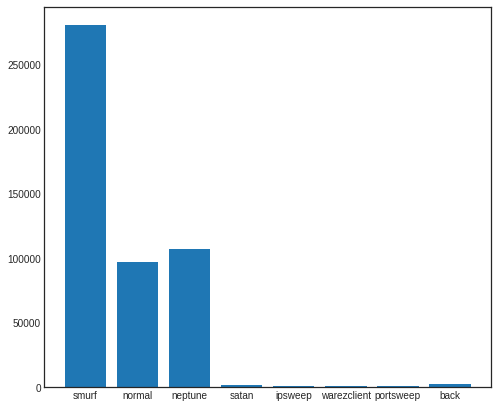

In [ ]:
from matplotlib import pyplot
attack_types = []
for c in counter_orig.keys():
  attack_types.append(label_mapping[c])
  
pyplot.figure(figsize=(8,7))
pyplot.bar(attack_types, counter_orig.values())
pyplot.show()

### SMOTE
Imbalanced classification involves developing predicitve models on classification datasets that have a class inbalance. Synthetic Minority Oversampling Technique, or SMOTE is an approach to address imbalanced dataset where minority class is oversampled. It creates new synthetic instances according to the neighbourhood of each example of the minority class.

In [ ]:
strategy_over = {0:201862, 1:187396, 2:239604, 4:178387, 5:195267, 3:216522, 7:173021}
strategy_under = {6:242063}
over = SMOTE(sampling_strategy = strategy_over)
under = RandomUnderSampler(sampling_strategy = strategy_under)

steps = [('o', over),('u', under)]
pipeline = Pipeline(steps=steps)
X_SMOTE, y_SMOTE = pipeline.fit_resample(X_SMOTE, y_SMOTE)

counter = Counter(y_SMOTE)
print(counter)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Counter({6.0: 242063, 2.0: 239604, 3.0: 216522, 0.0: 201862, 5.0: 195267, 1.0: 187396, 4.0: 178387, 7.0: 173021})


### Visualize count of Attack types after SMOTE
The bar graph below shows the number of instances for each attack type in the dataset after creating synthetic instances using SMOTE.

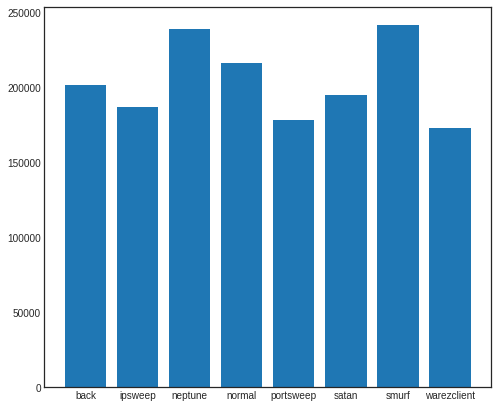

In [ ]:
from matplotlib import pyplot
attack_types = []
for c in counter.keys():
  attack_types.append(label_mapping[c])

pyplot.figure(figsize=(8,7))  
pyplot.bar(attack_types, counter.values())
pyplot.show()

In [ ]:
X_SMOTE = pd.DataFrame(X_SMOTE, columns=features_SMOTE.columns)
y_SMOTE = pd.DataFrame(y_SMOTE, columns=labels_SMOTE.columns)

### Train and Test Data Split

It is absolutely necessary to split the data into training, testing, and validation to make sure Machine Learning algorithms are learning well and can make predictions as accurately as possible. Here we use train_test_split to split 80% of the data as the train, 10% as the test and the rest 10% as the validation dataset.

In [ ]:
import random
list1 = [1,2,3,4,5,6]
random.shuffle(list1)
print(list1)
list2 = list1[:3]
print(list2)

[2, 1, 4, 3, 5, 6]
[2, 1, 4]


In [ ]:
from sklearn.model_selection import train_test_split 

train_features_SMOTE, rem_features, train_labels_SMOTE, rem_labels = train_test_split(X_SMOTE, y_SMOTE, train_size=0.8, shuffle=True)
valid_features_SMOTE, test_features_SMOTE, valid_labels_SMOTE, test_labels_SMOTE = train_test_split(rem_features, rem_labels, test_size=0.5, shuffle=True)

print("Train Dataset Feature Shape: ")
print(train_features_SMOTE.shape)
print("Test Dataset Feature Shape: ")
print(test_features_SMOTE.shape)
print("Valid Dataset Feature Shape: ")
print(valid_features_SMOTE.shape)
print("Train Dataset label Shape: ")
print(train_labels_SMOTE.shape)
print("Test Dataset label Shape: ")
print(test_labels_SMOTE.shape)
print("Valid Dataset label Shape: ")
print(valid_labels_SMOTE.shape)

Train Dataset Feature Shape: 
(1307297, 39)
Test Dataset Feature Shape: 
(163413, 39)
Valid Dataset Feature Shape: 
(163412, 39)
Train Dataset label Shape: 
(1307297, 1)
Test Dataset label Shape: 
(163413, 1)
Valid Dataset label Shape: 
(163412, 1)


In [ ]:
print(label_mapping)

{0: 'back', 1: 'ipsweep', 2: 'neptune', 3: 'normal', 4: 'portsweep', 5: 'satan', 6: 'smurf', 7: 'warezclient'}


### Visualize labels 
As we  can see below, the labels present in the dataframe belong to various types of attack. The proportion of the attacks present in the dataset are more uniform after creating synthetic data.

In [ ]:
lst = []
for i in range(valid_labels_SMOTE.shape[0]):
    lst.append(int(valid_labels_SMOTE.iloc[i]))

print(lst)

[2, 0, 7, 0, 4, 5, 2, 6, 1, 2, 4, 4, 1, 3, 2, 1, 1, 7, 5, 5, 5, 1, 4, 3, 3, 7, 2, 6, 4, 5, 5, 7, 3, 5, 6, 4, 5, 6, 6, 7, 7, 5, 5, 1, 3, 3, 7, 6, 0, 3, 4, 4, 3, 3, 4, 0, 4, 3, 6, 5, 5, 2, 2, 4, 1, 3, 6, 4, 1, 3, 6, 5, 5, 5, 2, 2, 7, 5, 1, 4, 5, 7, 7, 3, 1, 2, 5, 0, 6, 6, 0, 7, 6, 0, 7, 6, 3, 6, 0, 3, 6, 5, 2, 0, 1, 6, 1, 4, 6, 1, 2, 0, 5, 3, 5, 4, 2, 2, 2, 5, 6, 6, 4, 5, 4, 1, 1, 4, 3, 3, 0, 2, 3, 3, 1, 4, 0, 0, 7, 3, 1, 4, 4, 5, 1, 0, 1, 0, 4, 5, 6, 2, 0, 6, 1, 1, 2, 5, 6, 0, 3, 1, 4, 3, 1, 7, 2, 0, 4, 4, 6, 6, 3, 2, 5, 7, 5, 3, 0, 3, 3, 0, 5, 2, 4, 7, 0, 3, 3, 4, 3, 7, 2, 4, 7, 5, 2, 3, 2, 2, 3, 4, 5, 3, 3, 4, 5, 3, 3, 5, 2, 2, 4, 0, 5, 4, 1, 0, 7, 7, 6, 1, 2, 3, 5, 1, 6, 3, 2, 3, 0, 3, 5, 5, 2, 6, 5, 6, 1, 0, 6, 7, 4, 3, 3, 2, 4, 6, 6, 5, 5, 0, 6, 2, 0, 2, 6, 2, 2, 3, 7, 6, 5, 7, 7, 0, 6, 0, 5, 7, 6, 5, 5, 3, 1, 0, 6, 1, 3, 0, 6, 4, 1, 7, 2, 4, 7, 5, 4, 3, 3, 7, 5, 5, 4, 5, 6, 5, 2, 7, 2, 5, 5, 7, 5, 2, 6, 5, 4, 6, 5, 6, 3, 0, 6, 3, 2, 3, 3, 3, 2, 0, 1, 1, 1, 0, 5, 0, 5, 0, 2, 1, 4, 

In [ ]:
print(label_mapping)

{0: 'back', 1: 'ipsweep', 2: 'neptune', 3: 'normal', 4: 'portsweep', 5: 'satan', 6: 'smurf', 7: 'warezclient'}


### Fit model
Fit the model with the features and labels dataframe created from the train_test_split from the new dataset.

In [ ]:
rf.fit(train_features_SMOTE, train_labels_SMOTE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Testing

The test features are used to predict the labels and  test the performance of the Random Forest model.

The accuracy of the model using the training data.


In [ ]:
train_pred_labels_SMOTE = rf.predict(train_features_SMOTE)
accuracy, matrix, precision, recall, f1 = get_model_performance(train_labels_SMOTE, train_pred_labels_SMOTE)
print("The accuracy of the model: ", accuracy)
print("The precision of the model: ", precision)
print("The recall of the model: ", recall)
print("The f1 score of the model: ", f1)

The accuracy of the model:  0.999993115565935
The precision of the model:  0.9999928300449596
The recall of the model:  0.9999931735886176
The f1 score of the model:  0.9999930017949046


The accuracy of the model using the test data.

In [ ]:
test_pred_labels_SMOTE = rf.predict(test_features_SMOTE)
accuracy, matrix, precision, recall, f1 = get_model_performance(test_labels_SMOTE, test_pred_labels_SMOTE)
print("The accuracy of the model: ", accuracy)
print("The precision of the model: ", precision)
print("The recall of the model: ", recall)
print("The f1 score of the model: ", f1)

The accuracy of the model:  0.9999694026791014
The precision of the model:  0.9999675065707374
The recall of the model:  0.9999677716704158
The f1 score of the model:  0.9999676378613958


The training accuracy and test accuracy doesn't seem to have a lot of difference. Hence, it shows that the model was not overfit.

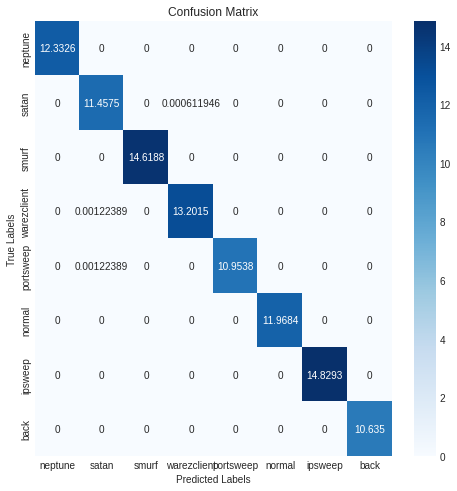

In [ ]:
plot_model_performance(matrix)

In [ ]:
print(valid_features_SMOTE.shape)

(163412, 39)


### Randomly selected instances for validation
The code below creates a list of lists named 'data' consisting of randomly selected instances from the validation dataset, where only features are included. It also creates a list of it's corresponding true labels named true_labels.

In [ ]:
import random
data = []
true_labels_SMOTE = []

for i in range(10):
  temp = random.randint(0, valid_features_SMOTE.shape[0])
  data.append(valid_features_SMOTE.iloc[temp].tolist())
  true_labels_SMOTE.append(valid_labels_SMOTE.iloc[temp])

for index, ele in enumerate(true_labels_SMOTE):
  true_labels_SMOTE[index] = label_mapping[int(ele)]

print(data)
print(true_labels_SMOTE)

[[0.0, 0.0, 14.0, 9.0, 1.4883707192251517e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 13.0, 9.0, 1.153775751337327e-08, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0019569471624266144, 0.043075362593532604, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.00784313725490196, 0.8918488730151881, 1.0, 0.0, 1.0, 0.5, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 14.0, 9.0, 1.4883707192251517e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 13.0, 9.0, 2.5959954405089858e-08, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0019569471624266144, 0.0019569471624266144, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.00392156862745098, 0.996078431372549, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0], 

### Create Dataframe
Create a pandas dataframe called new_data out of the list of lists of instances generated in the code cell above.

In [ ]:
new_data = pd.DataFrame(data)
print(new_data)
new_data.columns = valid_features_SMOTE.columns.tolist()
new_data

         0    1     2    3             4   ...   34   35   36    37    38
0  0.000000  0.0  14.0  9.0  1.488371e-06  ...  0.0  0.0  0.0  0.00  0.00
1  0.000000  0.0  13.0  9.0  1.153776e-08  ...  0.5  0.0  0.0  0.00  0.00
2  0.000000  0.0  14.0  9.0  1.488371e-06  ...  0.0  0.0  0.0  0.00  0.00
3  0.000000  0.0  13.0  9.0  2.595995e-08  ...  1.0  0.0  0.0  0.00  0.00
4  0.000000  1.0  45.0  5.0  0.000000e+00  ...  0.0  1.0  1.0  0.00  0.00
5  0.000000  1.0  19.0  9.0  4.817014e-07  ...  0.4  0.0  0.0  0.00  0.00
6  0.000000  1.0  22.0  9.0  7.865866e-05  ...  0.0  0.0  0.0  0.05  0.05
7  0.000017  1.0  18.0  9.0  1.740550e-06  ...  0.0  0.0  0.0  0.00  0.00
8  0.000000  0.0  14.0  9.0  1.488371e-06  ...  0.0  0.0  0.0  0.00  0.00
9  0.000000  1.0  45.0  1.0  0.000000e+00  ...  0.0  0.0  0.0  1.00  1.00

[10 rows x 39 columns]


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,lnum_compromised,lroot_shell,lsu_attempted,lnum_root,lnum_file_creations,lnum_shells,lnum_access_files,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0.000000,0.0,14.0,9.0,1.488371e-06,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0,0.0,1.00,0.00,0.0,1.000000,1.000000,1.00,0.00,1.00,0.0,0.0,0.0,0.00,0.00
1,0.000000,0.0,13.0,9.0,1.153776e-08,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.043075,0.0,0.0,0.0,0.0,1.00,0.00,1.0,0.007843,0.891849,1.00,0.00,1.00,0.5,0.0,0.0,0.00,0.00
2,0.000000,0.0,14.0,9.0,1.488371e-06,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0,0.0,1.00,0.00,0.0,1.000000,1.000000,1.00,0.00,1.00,0.0,0.0,0.0,0.00,0.00
3,0.000000,0.0,13.0,9.0,2.595995e-08,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.001957,0.0,0.0,0.0,0.0,1.00,0.00,0.0,0.003922,0.996078,1.00,0.00,1.00,1.0,0.0,0.0,0.00,0.00
4,0.000000,1.0,45.0,5.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.528376,0.029354,1.0,1.0,0.0,0.0,0.06,0.05,0.0,1.000000,0.058824,0.06,0.05,0.00,0.0,1.0,1.0,0.00,0.00
5,0.000000,1.0,19.0,9.0,4.817014e-07,0.000000,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003914,0.003914,0.0,0.0,0.0,0.0,1.00,0.00,0.0,0.007843,0.039216,1.00,0.00,1.00,0.4,0.0,0.0,0.00,0.00
6,0.000000,1.0,22.0,9.0,7.865866e-05,0.001619,0.0,0.0,0.0,0.066667,0.0,1.0,0.001131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010439,0.010439,0.0,0.0,0.0,0.0,1.00,0.00,0.0,0.166017,0.166017,1.00,0.00,0.02,0.0,0.0,0.0,0.05,0.05
7,0.000017,1.0,18.0,9.0,1.740550e-06,0.000477,0.0,0.0,0.0,0.933333,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.001957,0.001957,0.0,0.0,0.0,0.0,1.00,0.00,0.0,1.000000,0.347505,0.35,0.02,0.00,0.0,0.0,0.0,0.00,0.00
8,0.000000,0.0,14.0,9.0,1.488371e-06,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.998043,0.998043,0.0,0.0,0.0,0.0,1.00,0.00,0.0,1.000000,1.000000,1.00,0.00,1.00,0.0,0.0,0.0,0.00,0.00
9,0.000000,1.0,45.0,1.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.279843,0.031311,0.0,0.0,1.0,1.0,0.11,0.06,0.0,1.000000,0.062745,0.06,0.05,0.00,0.0,0.0,0.0,1.00,1.00


### Validate results
The randomly selected instances of data not used in the training and testing are used to make preidctions of it's label. 

In [ ]:
features_new_SMOTE = np.array(new_data)
pred_labels_SMOTE = rf.predict(features_new_SMOTE)
pred_labels_SMOTE = pred_labels_SMOTE.tolist()

for index, ele in enumerate(pred_labels_SMOTE):
  temp = label_mapping[int(ele)]
  pred_labels_SMOTE[index] = label_mapping[int(ele)]

print("True labels: ", true_labels_SMOTE)
print("Pred labels: ", pred_labels_SMOTE)

True labels:  ['smurf', 'ipsweep', 'smurf', 'ipsweep', 'neptune', 'warezclient', 'back', 'warezclient', 'smurf', 'neptune']
Pred labels:  ['smurf', 'ipsweep', 'smurf', 'ipsweep', 'neptune', 'warezclient', 'back', 'warezclient', 'smurf', 'neptune']


**In Confusion matrices, what differences did you observe? How do you think they are similar or dissimilar? Explain. (6 points)**

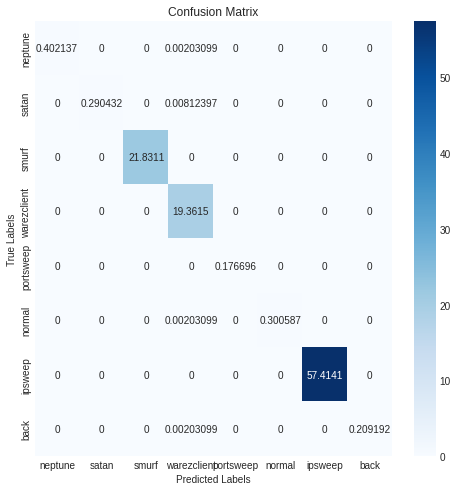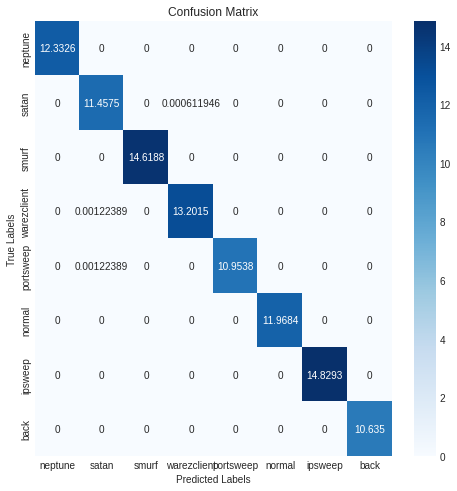


The similarity in both confusion matrices are higher true positive rates and low false positives eventually giving high performances in terms of accuracy, precision, recall, and F1 score. But There is a notable difference in two matrices in terms of class label representation and real time applicability. 

In the first confusion matrix obtained from an imbalanced dataset, the overall dataset is dominated by three attacks namely ipsweep, smurf and warezclient. It means the model is mainly trained for these three classes of data. But for other 5 classes, the model is not sufficiently trained as demonstrated by some misclassification on those class labels. Such model developed from an imbalanced dataset may not be applicable in real time, though it has high accuracy, beecause in minority class, it may not perform well.

In the second confusion matrix generated from a balanced dataset, on the other hand, is representative for all 8 class labels. To achieve a balanced dataset, We have applied the SMOTE method with oversampling (for minority classes) and undersampling(for dominant class). This model can perform well in real time as it is generalized for all classes with negligible misclassification.

**What are imbalanced and balanced datasets? What are their roles in Machine Learning? (4 points)**

In an imbalanced dataset, there is a difference in proportion of data related to different class labels. The dataset is dominated by one or few classes and other classes have very few proportions. In other words, the dataset is not representative for all class labels and not well distributed. Whereas a balanced dataset is representative for all class labels with nearly the same proportion. 

In machine learning, we develop generalized models to classify/predict unknown data. But if the model is trained from not-representative imbalanced dataset, it may not be trained for minority class(es) and biased towards dominant class(es). Such a model is not applicable in real time even though it gives high accuracy. So, it's worthwhile to make a balanced dataset before training the model to get a generalized model representative to all class labels. A Model from a balanced dataset can perform well for all data irrespective of their classes.

## Extra Credit work

**What other classifiers can you use? Use one other classifier and compare the result from above.**

I have tried a Naive Bayes classifier (attached in seperate file) with a similar approach to Random Forest and presented the following comparison chart. In the case of random forest, model performance metrics, such as Accuracy, Precision, Recall and F1 Score, all are high in both imbalanced and balanced dataset. But in the case of Naive Bayes classifier, low performances were observed in imbalanced data which improved significantly in balanced dataset. In both (B & IMB) cases, Random forest outperformed Naive Bayes. So major takeaways are:



1.   Random Forest is better than Naive Bayes for an imbalanced dataset.
2.   Naive Bayes classifier performance significantly degraded in an imbalanced dataset.
3.   Machine learning performance as well as its applicability improves in a balanced dataset than an imbalanced dataset.




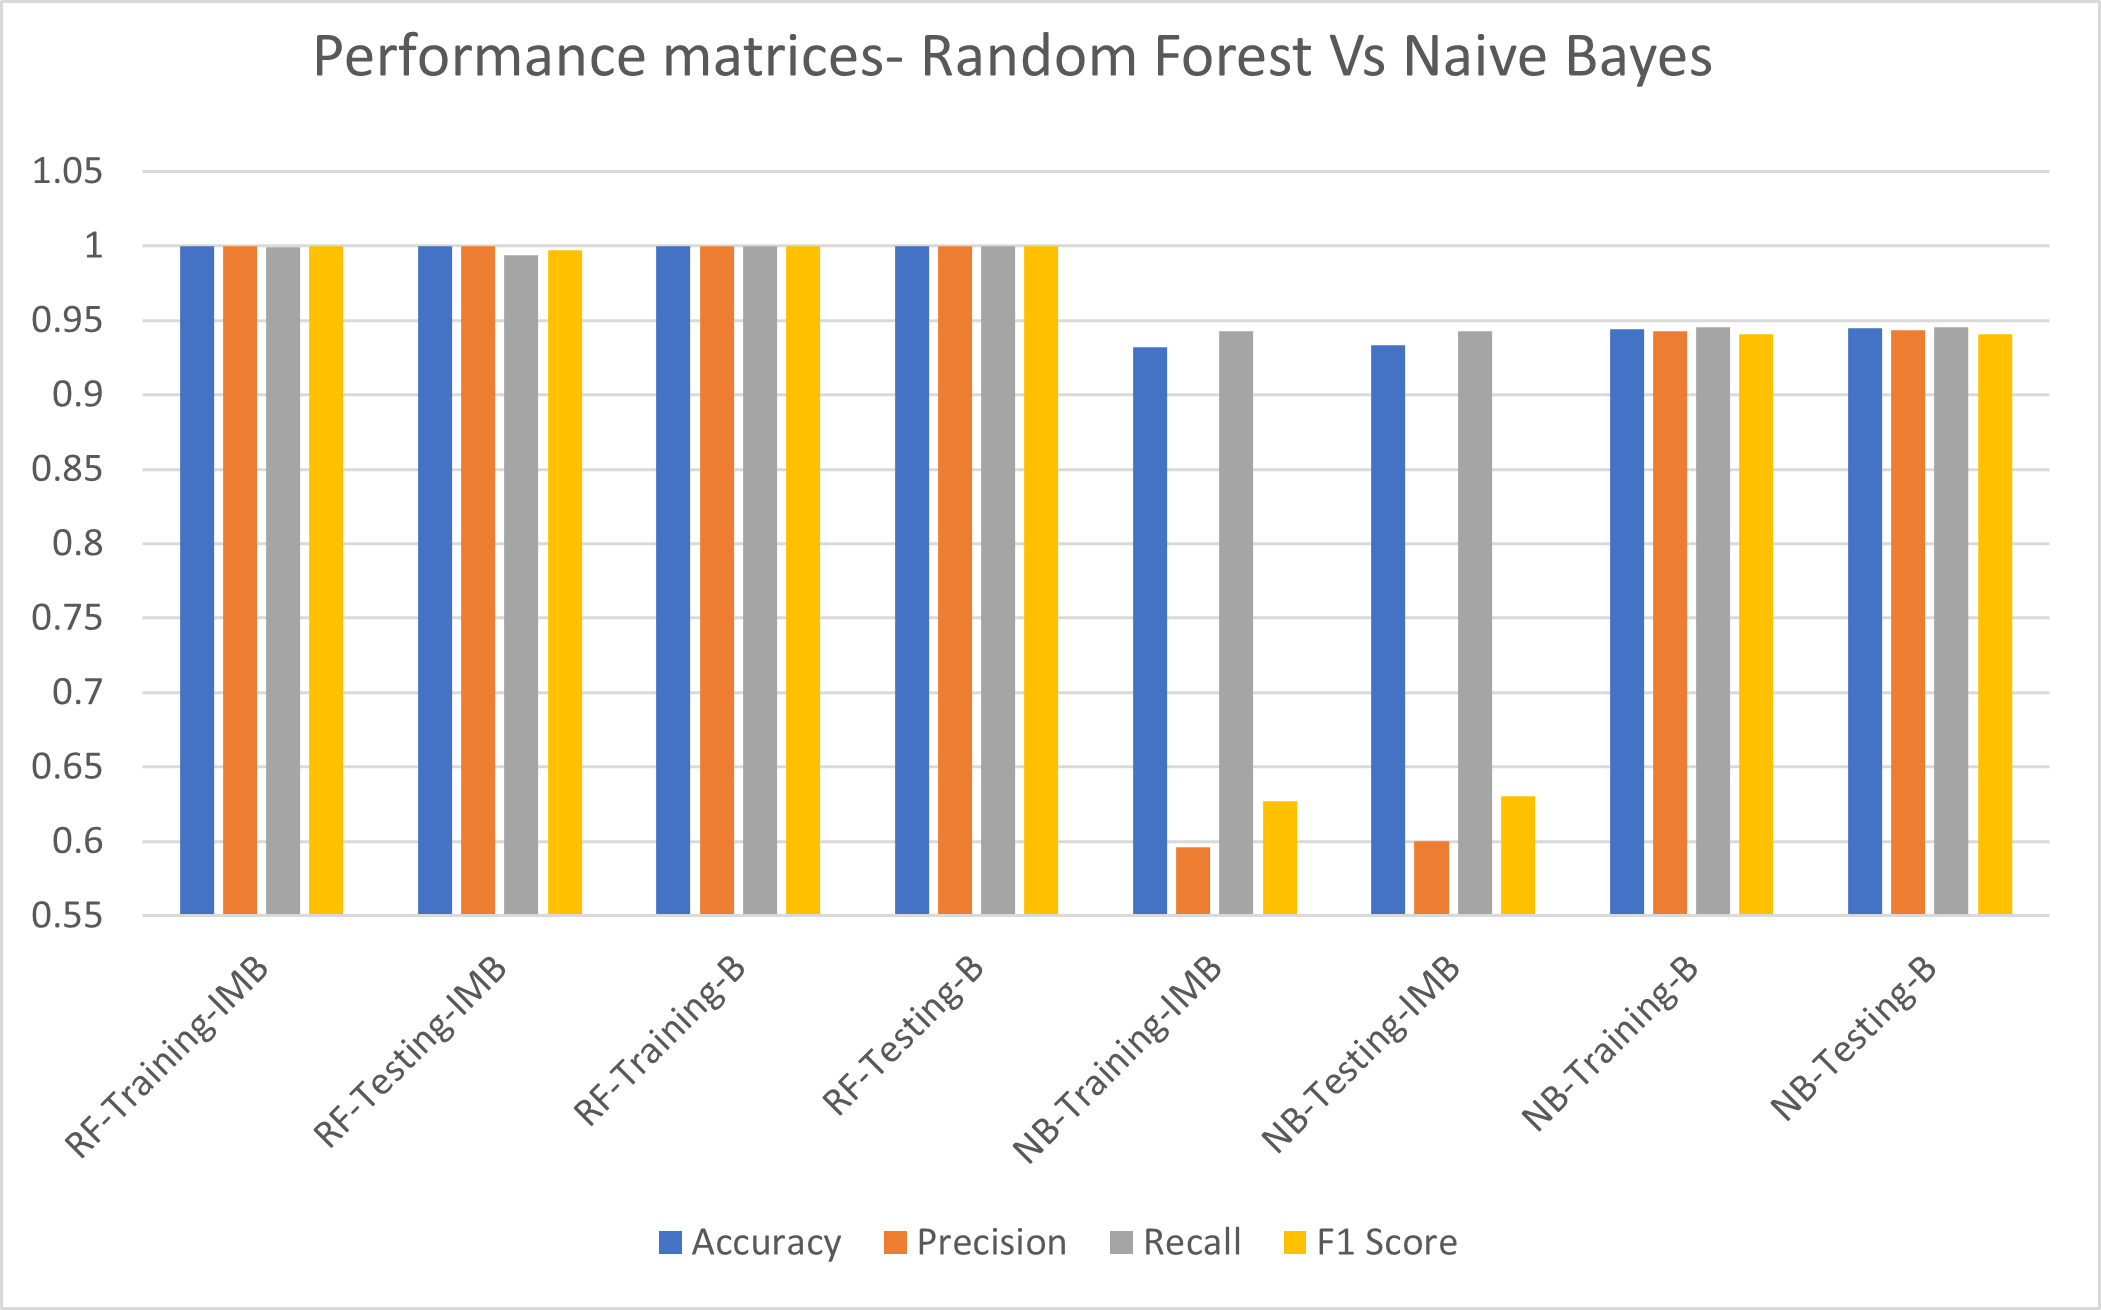

Colab Link for Random Forest: https://colab.research.google.com/drive/14Ks0CeHh_nrjf6IVCfr6WGPeouET7SMt?usp=sharing

Colab Link for Naive Bayes: https://colab.research.google.com/drive/1eGeawGqIFtvpk3RMXW3Xs5yH1YCsowuI?usp=sharing